# import

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from ast import literal_eval
import scipy
#functions

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)



# PRESLEEP ANALYSIS 

In [2]:

# load in the presleep data - extract number of sequenes found
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"
presleep_events_per_min = []
mirs = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file_ = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file_)+ r'//_final_analysis_output//'
    clust_events_per_min = 0
    all_chunks_len = 0
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
                # only sequential events
                clust_events_per_min += len(replay_clusts[replay_clusts.ordering_classification == 'sequential'])
                all_chunks_len += interval_length/60
    if all_chunks_len > 0:
        presleep_events_per_min += [clust_events_per_min/all_chunks_len]
        mirs += [file_.split('_run')[0]]

post_sleep_replay_rates = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\replay_rate_old_data\replay_rates.csv")

100%|██████████| 31/31 [06:01<00:00, 11.67s/it]


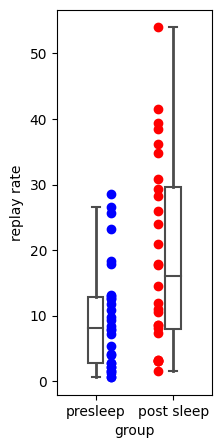

In [3]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

for epms in presleep_events_per_min:
    ax.plot(0.2,epms,'o', color = 'blue')
    
ps_rr = post_sleep_replay_rates.reactivations_per_min.values   
ax.plot([0.8]*len(ps_rr),ps_rr,'o', color = 'red')

plt_df = pd.DataFrame({'group': (['presleep'] * len(presleep_events_per_min)) + (['post sleep'] * len(ps_rr)) , 'replay rate': list(presleep_events_per_min)+list(ps_rr)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-replay-rate.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")


In [4]:

# Remove NaN values
presleep_events_per_min_clean = np.array(presleep_events_per_min)[~np.isnan(presleep_events_per_min)]
ps_rr_clean = np.array(ps_rr)[~np.isnan(ps_rr)]

scipy.stats.shapiro(presleep_events_per_min_clean)
scipy.stats.shapiro(ps_rr_clean)
# non parametric

#indipendent, Wilcoxon Rank-Sum test
scipy.stats.ranksums(presleep_events_per_min_clean, ps_rr_clean)

RanksumsResult(statistic=-2.6452936873802777, pvalue=0.00816200426767409)

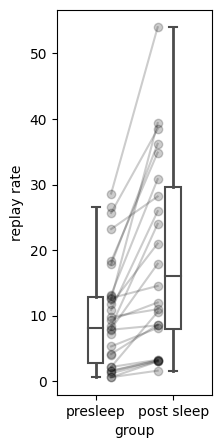

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
for index, mir in enumerate(mirs):
    pre_events = presleep_events_per_min[index]
    if mir in post_sleep_replay_rates.mirs.values:
        post_events = post_sleep_replay_rates[post_sleep_replay_rates.mirs == mir].reactivations_per_min.values[0]
        ax.plot([0.2,0.8],[pre_events,post_events],'o-', color = 'k', alpha = 0.2)
        
plt_df = pd.DataFrame({'group': (['presleep'] * len(presleep_events_per_min)) + (['post sleep'] * len(ps_rr)) , 'replay rate': list(presleep_events_per_min)+list(ps_rr)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-replay-rate-connected.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

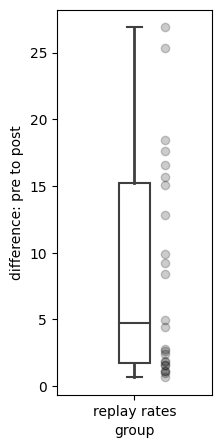

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
diffs = []
for index, mir in enumerate(mirs):
    pre_events = presleep_events_per_min[index]
    if mir in post_sleep_replay_rates.mirs.values:
        post_events = post_sleep_replay_rates[post_sleep_replay_rates.mirs == mir].reactivations_per_min.values[0]
        diff = post_events - pre_events
        diffs += [diff]
        ax.plot([0.2],diff,'o', color = 'k', alpha = 0.2)
        
plt_df = pd.DataFrame({'group': (['replay rates'] * len(diffs)), 'difference: pre to post': diffs})
ax = sns.boxplot(y='difference: pre to post', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-replay-rate-diff.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")


# preprocess event details

In [7]:


PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"

# PP_PATH =  r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
number_of_spikes = []
event_lengths = []
number_of_neurons = []
mirs = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file_ = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file_)+ r'//_final_analysis_output//'
    chunk_number_of_spikes = []
    chunk_event_lengths = []
    chunk_number_of_neurons = []
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                filtered_replay_clusts = replay_clusts[replay_clusts.ordering_classification == 'sequential']
                chunk_number_of_spikes += [list(filtered_replay_clusts.num_spikes.values)]
                chunk_event_lengths += [list(filtered_replay_clusts.event_length.values)]
                n_neurons = []
                for clusters in filtered_replay_clusts.cluster_neurons:
                    n_neurons += [len(np.unique(literal_eval(clusters)))]
                chunk_number_of_neurons += [n_neurons]
                
    mirs += [file_.split('_run')[0]]
    number_of_spikes += [chunk_number_of_spikes]
    event_lengths += [chunk_event_lengths]
    number_of_neurons += [chunk_number_of_neurons]  
    
out_df = pd.DataFrame({'mirs':mirs,'number_of_spikes_per_event_per_chunk':number_of_spikes,'event_lengths_per_event_per_chunk':event_lengths,'number_of_neurons_per_event_per_chunk':number_of_neurons}) 
out_df.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv",index = False)

100%|██████████| 31/31 [06:02<00:00, 11.69s/it]


# load and plot

In [8]:
postsleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\postsleep_event_details.csv")
presleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv")


c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


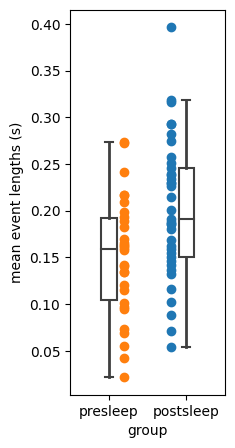

In [9]:
mean_neurons = []
for item in postsleep_event_details.event_lengths_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.event_lengths_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'mean event lengths (s)': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='mean event lengths (s)', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


SaveFig('pre-post-event-length.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [10]:


# Remove NaN values
presleep_clean = np.array(pre_mean_neurons)[~np.isnan(pre_mean_neurons)]
post_clean = np.array(mean_neurons)[~np.isnan(mean_neurons)]

print(scipy.stats.shapiro(presleep_clean))
print(scipy.stats.shapiro(post_clean))

#parametric

# ind t test
scipy.stats.ttest_ind(presleep_clean,post_clean)

ShapiroResult(statistic=0.9854181555860531, pvalue=0.9440877889687044)
ShapiroResult(statistic=0.9890546809376314, pvalue=0.9699504486195011)


TtestResult(statistic=-2.952189100461933, pvalue=0.0043861767317465205, df=65.0)

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


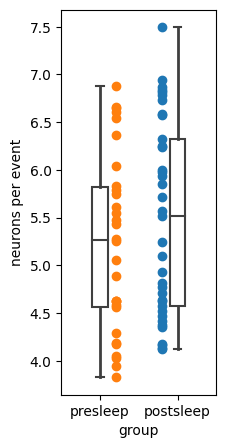

In [11]:
mean_neurons = []
for item in postsleep_event_details.number_of_neurons_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.number_of_neurons_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'neurons per event': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='neurons per event', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('neurons-per-event.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [12]:

# Remove NaN values
presleep_clean = np.array(pre_mean_neurons)[~np.isnan(pre_mean_neurons)]
post_clean = np.array(mean_neurons)[~np.isnan(mean_neurons)]

print(scipy.stats.shapiro(presleep_clean))
print(scipy.stats.shapiro(post_clean))

#non parametric

#indipendent, Wilcoxon Rank-Sum test
scipy.stats.ranksums(presleep_clean,post_clean)

ShapiroResult(statistic=0.9426393607836691, pvalue=0.10714487311900522)
ShapiroResult(statistic=0.9191407241432415, pvalue=0.010484009387248498)


RanksumsResult(statistic=-1.0339237932144132, pvalue=0.3011717908311138)

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


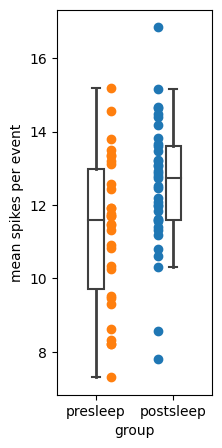

In [13]:
mean_neurons = []
for item in postsleep_event_details.number_of_spikes_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.number_of_spikes_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'mean spikes per event': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='mean spikes per event', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('pre-post-spikes-per-event.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [14]:

# Remove NaN values
presleep_clean = np.array(pre_mean_neurons)[~np.isnan(pre_mean_neurons)]
post_clean = np.array(mean_neurons)[~np.isnan(mean_neurons)]

print(scipy.stats.shapiro(presleep_clean))
print(scipy.stats.shapiro(post_clean))

#parametric

# ind t test
scipy.stats.ttest_ind(presleep_clean,post_clean)

ShapiroResult(statistic=0.9736347336727063, pvalue=0.6425938122325177)
ShapiroResult(statistic=0.9745358066407458, pvalue=0.5444022319207653)


TtestResult(statistic=-2.681469325508937, pvalue=0.009281302676323199, df=65.0)

# firing rate control

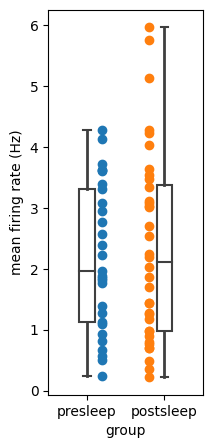

In [15]:
presleep_average_firing_rates = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_average_firing_rates.csv")
postsleep_average_firing_rates = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\replay_rate_old_data\average_firing_rates.csv")

bool_1 = []
for item in presleep_average_firing_rates.mirs:
    if item in presleep_event_details.mirs.values:
        bool_1 += [True]
    else:
        bool_1 += [False]
        
bool_2 = []
for item in postsleep_average_firing_rates.mirs:
    if item in postsleep_event_details.mirs.values:
        bool_2 += [True]
    else:
        bool_2 += [False]
        
pre = presleep_average_firing_rates[bool_1].average_firing_rates.values
post = postsleep_average_firing_rates[bool_2].average_firing_rates.values

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.2] * len(pre),pre,'o')
ax.plot([0.8] * len(post),post,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre))+(['postsleep'] * len(post)), 'mean firing rate (Hz)': list(pre)+list(post)})
ax = sns.boxplot(y='mean firing rate (Hz)', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

SaveFig('pre-post-firing-rate-control.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\presleep\\")

In [16]:


print(scipy.stats.shapiro(pre))
print(scipy.stats.shapiro(post))

#non parametric

#indipendent, Wilcoxon Rank-Sum test
scipy.stats.ranksums(pre,post)

ShapiroResult(statistic=0.951025621714755, pvalue=0.19460186435686694)
ShapiroResult(statistic=0.9355716482703269, pvalue=0.037045802969689845)


RanksumsResult(statistic=-0.10557434432865279, pvalue=0.9159200812258538)